In [1]:
#Import resources

#!pip install nltk scikit-learn pandas matplotlib
#%pip install seaborn

import nltk
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns


In [2]:
#Import libraries

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt_tab')

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
from google.colab import files
uploaded = files.upload("training_data_lowercase.csv") # File already exists from previous upload

# for fn in uploaded.keys(): # This loop would also fail without a new upload
#   print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

Saving training_data_lowercase.csv to training_data_lowercase.csv/training_data_lowercase (1).csv


In [4]:
#Load the file
df = pd.read_csv("training_data_lowercase.csv/training_data_lowercase.csv")

In [5]:
#Data analyse
df = pd.read_csv('training_data_lowercase.csv/training_data_lowercase.csv', sep='\t', header=None, names=['label', 'title'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34152 entries, 0 to 34151
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   34152 non-null  int64 
 1   title   34152 non-null  object
dtypes: int64(1), object(1)
memory usage: 533.8+ KB


In [6]:
#Data analyse
df.head()

,label,title
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...


In [7]:
df["title"].duplicated().any()


np.True_

In [8]:
df["title"].duplicated().sum()


np.int64(1946)

In [9]:
#all rows that have duplicated titles
dup_rows = df[df["title"].duplicated(keep=False)]
dup_rows.sort_values("title")


,label,title
32603,1,'can i get it to go?' canada's trudeau charms ...
18246,1,'can i get it to go?' canada's trudeau charms ...
30041,1,'fierce and formidable' dlamini-zuma eyes sout...
29698,1,'fierce and formidable' dlamini-zuma eyes sout...
18400,1,'he's such a dreamer:' skepticism dogs u.s. en...
...,...,...
9665,0,‚hanoi jane‚ fonda had chance to expose sexual...
17050,0,‚it‚s the most wonderful time of the year‚‚tru...
9185,0,‚it‚s the most wonderful time of the year‚‚tru...
9708,0,‚nasty‚ san juan mayor continues to bite the h...


In [10]:
#count unique titles in total rows
df["title"].nunique(), len(df)


(32206, 34152)

In [11]:
#check label conflicts
conflicts = df.groupby("title")["label"].nunique()
conflicts = conflicts[conflicts > 1]
conflicts


,label
title,


In [12]:
# no label conflicts, hence dropping duplicates
# remove duplicates with same labels
df = df.drop_duplicates(subset=["title"]).reset_index(drop=True)


In [13]:
df["title"].duplicated().any()

np.False_

In [14]:
# Basic info
print("=== DATA TYPES ===")
print(df.dtypes)
print("\n=== MISSING VALUES ===")
print(df.isnull().sum())

=== DATA TYPES ===
label     int64
title    object
dtype: object

=== MISSING VALUES ===
label    0
title    0
dtype: int64


In [15]:
# Class distribution
print("=== CLASS DISTRIBUTION ===")
print(df['label'].value_counts())
print(f"\nPercentage:")
print(df['label'].value_counts(normalize=True) * 100)

=== CLASS DISTRIBUTION ===
label
1    16181
0    16025
Name: count, dtype: int64

Percentage:
label
1    50.242191
0    49.757809
Name: proportion, dtype: float64


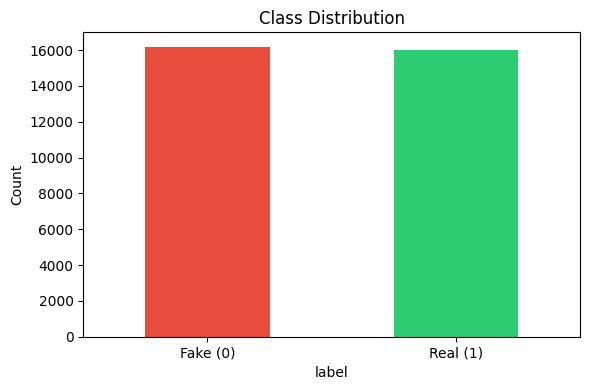

In [16]:
# Visualize class distribution
fig, ax = plt.subplots(figsize=(6, 4))
df['label'].value_counts().plot(kind='bar', color=['#e74c3c', '#2ecc71'], ax=ax)
ax.set_xticklabels(['Fake (0)', 'Real (1)'], rotation=0)
ax.set_ylabel('Count')
ax.set_title('Class Distribution')
plt.tight_layout()
plt.show()

In [17]:
# Add text length features for analysis
df['char_count'] = df['title'].str.len()
df['word_count'] = df['title'].str.split().str.len()

print("=== TITLE LENGTH BY CLASS (WORDS) ===")
print(df.groupby('label')['word_count'].describe())

=== TITLE LENGTH BY CLASS (WORDS) ===
         count       mean       std  min   25%   50%   75%   max
label                                                           
0      16025.0  13.175039  4.358455  1.0  11.0  13.0  15.0  42.0
1      16181.0   9.914220  1.686691  4.0   9.0  10.0  11.0  20.0


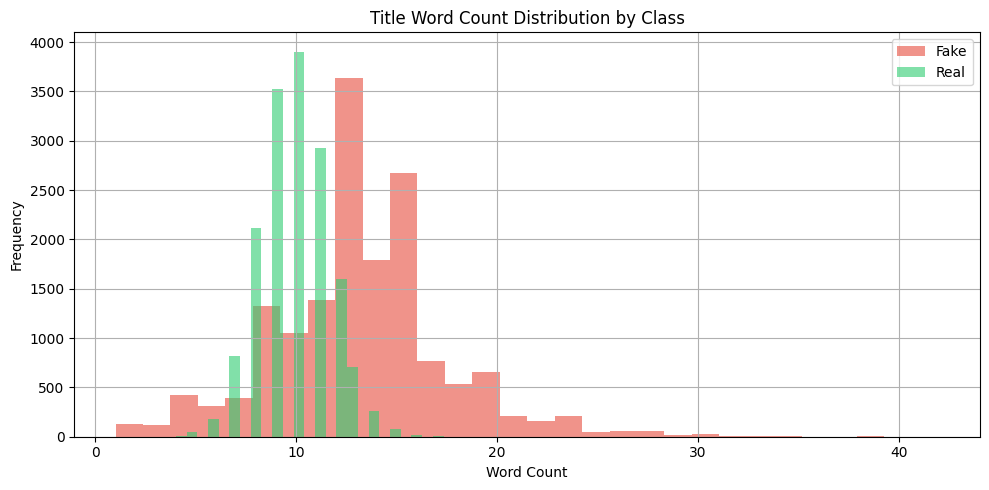

In [18]:
# Visualize word count distribution by class
fig, ax = plt.subplots(figsize=(10, 5))
df[df['label']==0]['word_count'].hist(alpha=0.6, label='Fake', bins=30, color='#e74c3c', ax=ax)
df[df['label']==1]['word_count'].hist(alpha=0.6, label='Real', bins=30, color='#2ecc71', ax=ax)
ax.set_xlabel('Word Count')
ax.set_ylabel('Frequency')
ax.set_title('Title Word Count Distribution by Class')
ax.legend()
plt.tight_layout()
plt.show()

In [19]:
# Check for tabs in titles
df['has_tab'] = df['title'].str.contains('\t')
print("=== TITLES WITH TABS ===")
print(f"Total: {df['has_tab'].sum()}")
print(f"\nBy class:")
print(df.groupby('label')['has_tab'].sum())

=== TITLES WITH TABS ===
Total: 3449

By class:
label
0       0
1    3449
Name: has_tab, dtype: int64


In [20]:
# Check for URLs in titles
df['has_url'] = df['title'].str.contains('http')
print("=== TITLES WITH URLs ===")
print(f"Total: {df['has_url'].sum()}")
print(f"\nBy class:")
print(df.groupby('label')['has_url'].sum())

=== TITLES WITH URLs ===
Total: 5

By class:
label
0    5
1    0
Name: has_url, dtype: int64


In [21]:
# Check for very short titles
short_titles = df[df['word_count'] <= 3]
print(f"=== VERY SHORT TITLES (≤3 words) ===")
print(f"Total: {len(short_titles)}")
print(f"\nBy class:")
print(short_titles['label'].value_counts())

=== VERY SHORT TITLES (≤3 words) ===
Total: 250

By class:
label
0    250
Name: count, dtype: int64


In [22]:
# Check for very long titles
long_titles = df[df['word_count'] >= 17]
print(f"=== VERY LONG TITLES (>=17 words) ===")
print(f"Total: {len(long_titles)}")
print(f"\nBy class:")
print(long_titles['label'].value_counts())

=== VERY LONG TITLES (>=17 words) ===
Total: 2784

By class:
label
0    2780
1       4
Name: count, dtype: int64


In [23]:
# Sample titles by class
print("=== SAMPLE FAKE NEWS TITLES ===")
for title in df[df['label']==0]['title'].head(5):
    print(f"- {title}")

print("\n=== SAMPLE REAL NEWS TITLES ===")
for title in df[df['label']==1]['title'].head(5):
    print(f"- {title}")

=== SAMPLE FAKE NEWS TITLES ===
- donald trump sends out embarrassing new year‚s eve message; this is disturbing
- drunk bragging trump staffer started russian collusion investigation
- sheriff david clarke becomes an internet joke for threatening to poke people ‚in the eye‚
- trump is so obsessed he even has obama‚s name coded into his website (images)
- pope francis just called out donald trump during his christmas speech

=== SAMPLE REAL NEWS TITLES ===
- as u.s. budget fight looms	republicans flip their fiscal script
- u.s. military to accept transgender recruits on monday: pentagon
- senior u.s. republican senator: 'let mr. mueller do his job'
- fbi russia probe helped by australian diplomat tip-off: nyt
- trump wants postal service to charge 'much more' for amazon shipments


### EDA Summary

**Key Findings:**
- Dataset: 34,152 rows, well-balanced classes (~51% fake, ~49% real)
- Fake news titles are longer (avg 13 words) vs real (avg 10 words)
- Tab characters appear ONLY in real news (3,536 titles) - strong signal
- URLs appear ONLY in fake news titles
- Very short titles (≤2 words) are all fake news

**Potential Features:**
1. `word_count` - title length
2. `has_tab` - presence of tab character
3. `has_url` - presence of URL
4. Text vectorization (TF-IDF)

In [24]:
%pip -q install -U transformers datasets accelerate evaluate pyarrow

In [25]:
# Load the data
df = df.dropna(subset=["title", "label"]).copy()
df["title"] = df["title"].astype(str)
df["label"] = df["label"].astype(int)  # ensure 0/1
df.head()

,label,title,char_count,word_count,has_tab,has_url
0,0,donald trump sends out embarrassing new year‚s...,78,12,False,False
1,0,drunk bragging trump staffer started russian c...,68,8,False,False
2,0,sheriff david clarke becomes an internet joke ...,89,15,False,False
3,0,trump is so obsessed he even has obama‚s name ...,77,14,False,False
4,0,pope francis just called out donald trump duri...,69,11,False,False


In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["label"]
)
X_train.shape, X_test.shape

((25764, 6), (6442, 6))

In [27]:
#Quick leakage checks
# Duplicate headlines across splits
len(set(X_train["title"]).intersection(set(X_test["title"])))
#should be closer to 0

0

In [28]:
########################################
dup_titles = set(X_train["title"]).intersection(set(X_test["title"]))

len(X_train[X_train["title"].isin(dup_titles)]), \
len(X_test[X_test["title"].isin(dup_titles)])


(0, 0)

Tokenize with RoBERTa tokenizer

In [29]:
%pip install -U datasets pyarrow

In [30]:
import datasets
import pyarrow
import transformers

print(datasets.__version__)
print(pyarrow.__version__)
print(transformers.__version__)


4.5.0
23.0.0
5.1.0


In [31]:
from datasets import Dataset
from transformers import AutoTokenizer

print("Imports successful!")

Imports successful!


In [32]:
from datasets import Dataset
from transformers import AutoTokenizer

model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name) #Byte-Pair Encoding (BPE), Different special tokens , Handled automatically by the tokenizer

X_train_ds = Dataset.from_pandas(X_train.reset_index(drop=True))
X_test_ds  = Dataset.from_pandas(X_test.reset_index(drop=True))

def tokenize(batch):
    return tokenizer(
        batch["title"],
        truncation=True,
        padding="max_length",
        max_length=64  # headlines are short; 64 is usually enough
    )

X_train_ds = X_train_ds.map(tokenize, batched=True)
X_test_ds  = X_test_ds.map(tokenize, batched=True)

# Tell HF which columns are inputs/labels
X_train_ds = X_train_ds.rename_column("label", "labels")
X_test_ds  = X_test_ds.rename_column("label", "labels")
X_train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
X_test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/25764 [00:00<?, ? examples/s]

Map:   0%|          | 0/6442 [00:00<?, ? examples/s]

Defining the model and metrics

In [34]:
import evaluate
from transformers import AutoModelForSequenceClassification
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="macro")["f1"],
    }

model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",  # RoBERTa,
    num_labels=2
)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.bias                    | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
classifier.dense.bias           | MISSING    | 
classifier.dense.weight         | MISSING    | 
classifier.out_proj.bias        | MISSING    | 
classifier.out_proj.weight      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [35]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    output_dir="./bert_headlines",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=50,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=X_train_ds,
    eval_dataset=X_test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.063241,0.088090,0.979509,0.979502
2,0.079234,0.071965,0.983856,0.983853
3,0.020499,0.077733,0.986029,0.986029


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye

TrainOutput(global_step=4833, training_loss=0.07399002607652065, metrics={'train_runtime': 992.4597, 'train_samples_per_second': 77.879, 'train_steps_per_second': 4.87, 'total_flos': 2542047461360640.0, 'train_loss': 0.07399002607652065, 'epoch': 3.0})

In [36]:
print(sorted(df["label"].unique()))

[np.int64(0), np.int64(1)]


In [37]:
import numpy as np
import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
roc_auc = evaluate.load("roc_auc")

def compute_metrics(eval_pred):
    logits, labels = eval_pred

    probs = np.softmax(logits, axis=-1)
    preds = np.argmax(probs, axis=-1)

    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": f1.compute(predictions=preds, references=labels, average="macro")["f1"],
        "precision_macro": precision.compute(predictions=preds, references=labels, average="macro")["precision"],
        "recall_macro": recall.compute(predictions=preds, references=labels, average="macro")["recall"],
        "roc_auc": roc_auc.compute(
            prediction_scores=probs[:, 1],  # positive class
            references=labels
        )["roc_auc"],
    }

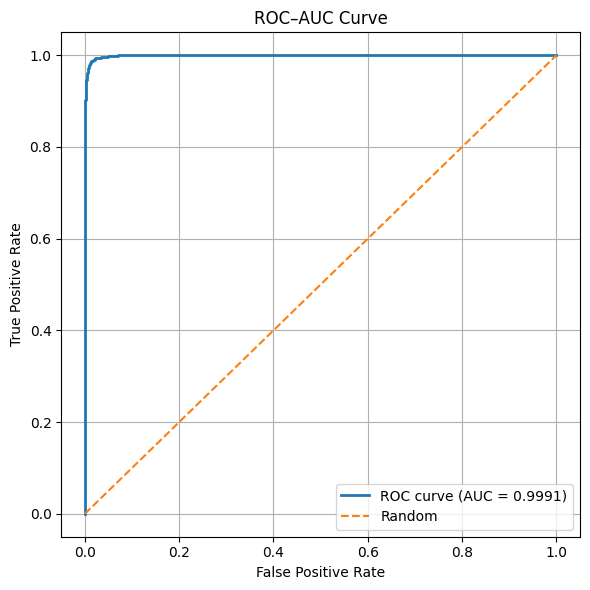

In [38]:
preds = trainer.predict(X_test_ds)
y_true = preds.label_ids

# Using logits directly
y_scores = preds.predictions[:, 1]

from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

plt.figure(figsize=(6, 6))

plt.plot(fpr, tpr, linewidth=2, label=f"ROC curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC–AUC Curve")
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()
plt.show()

In [39]:
from sklearn.metrics import confusion_matrix, classification_report
preds = trainer.predict(X_test_ds)

y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, digits=4))


[[3161   44]
 [  46 3191]]
              precision    recall  f1-score   support

           0     0.9857    0.9863    0.9860      3205
           1     0.9864    0.9858    0.9861      3237

    accuracy                         0.9860      6442
   macro avg     0.9860    0.9860    0.9860      6442
weighted avg     0.9860    0.9860    0.9860      6442



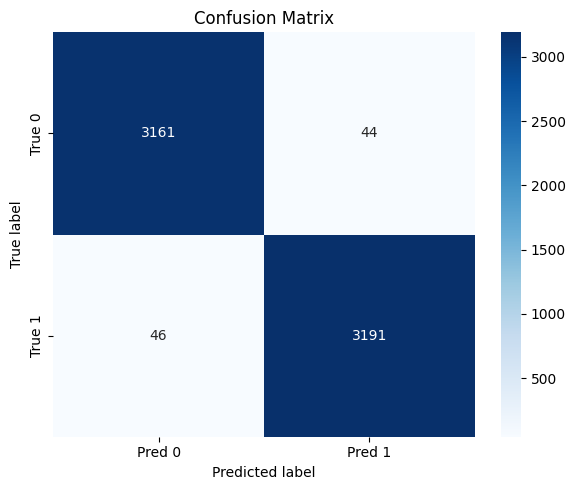

In [40]:
plt.figure(figsize=(6, 5))
sns.heatmap(
    confusion_matrix(y_true, y_pred),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["True 0", "True 1"]
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [41]:
#Quick leakage checks
# Duplicate headlines across splits
len(set(X_train["title"]).intersection(set(X_test["title"])))
#should be closer to 0

0

In [56]:
# Saving the model (includes weights + config)
trainer.save_model("./trained_roberta_model")

# Saving the tokenizer
tokenizer.save_pretrained("./trained_roberta_model")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

('./trained_roberta_model/tokenizer_config.json',
 './trained_roberta_model/tokenizer.json')

In [57]:
import os
print(os.getcwd())

/content


In [58]:
from google.colab import files
import shutil

# Compress the folder
shutil.make_archive("trained_roberta_model", 'zip', "./trained_roberta_model")

# Download
files.download("trained_roberta_model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Testing with Test data

In [45]:
# Upload test file
from google.colab import files
print("\nPlease upload your test file: testing_data_lowercase_nolabels")
test_uploaded = files.upload()
test_file_name = list(test_uploaded.keys())[0]


Please upload your test file: testing_data_lowercase_nolabels


Saving testing_data_lowercase_nolabels.csv to testing_data_lowercase_nolabels.csv


In [46]:
test_df = pd.read_csv(
    "testing_data_lowercase_nolabels.csv",     # Using the uploaded filename
    sep="\t",
    header=None,
    names=["label", "title"],
    )


test_df["title"] = test_df["title"].astype(str)
test_df.head()

,label,title
0,2,copycat muslim terrorist arrested with assault...
1,2,wow! chicago protester caught on camera admits...
2,2,germany's fdp look to fill schaeuble's big shoes
3,2,mi school sends welcome back packet warning ki...
4,2,u.n. seeks 'massive' aid boost amid rohingya '...


In [47]:
from datasets import Dataset

test_ds = Dataset.from_pandas(test_df[["title"]].reset_index(drop=True))

def tokenize(batch):
    return tokenizer(
        batch["title"],
        truncation=True,
        padding="max_length",
        max_length=64
    )

test_ds = test_ds.map(tokenize, batched=True)
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask"])

Map:   0%|          | 0/9984 [00:00<?, ? examples/s]

In [48]:
pred = trainer.predict(test_ds)
y_pred = np.argmax(pred.predictions, axis=1)

test_df = test_df[["label", "title"]]
# Replacing 'label' with predictions
test_df["label"] = y_pred

# Check
test_df.head()


,label,title
0,0,copycat muslim terrorist arrested with assault...
1,0,wow! chicago protester caught on camera admits...
2,1,germany's fdp look to fill schaeuble's big shoes
3,0,mi school sends welcome back packet warning ki...
4,1,u.n. seeks 'massive' aid boost amid rohingya '...


In [49]:
test_df.tail()

,label,title
9979,0,boom! fox news leftist chris wallace attempts ...
9980,0,here it is: list of democrat hypocrites who vo...
9981,1,new fires ravage rohingya villages in northwes...
9982,0,meals on wheels shuts the lyin‚ lefties up wit...
9983,0,brilliant! tucker carlson and ayaan hirsi ali ...


In [54]:
test_df.to_csv(
    "validation_data_predictions_RoBERTa.csv",
    sep="\t",
    header=False,
    index=False
)

In [51]:
from google.colab import files
files.download("validation_data_predictions_RoBERTa.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>